[Basics Quickstart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

In [3]:
# torch Dataset stores data and their labels; DataLoader wraps an iterable around Dataset
# PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
# The torchvision.datasets module contains Dataset objects. Use the FashionMNIST dataset
# Download training data from open datasets.
training_data = datasets.FashionMNIST(           # torchvision datasets for train
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(          # torchvision datasets for test
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [01:04<00:00, 412kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:10<00:00, 410kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 13.8MB/s]


In [6]:
# We pass the Dataset as an argument to DataLoader.
# This wraps an iterable over our dataset, 
# and supports automatic batching, sampling, shuffling and multiprocess data loading.
# Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

batch_size = 64
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


[Data in PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

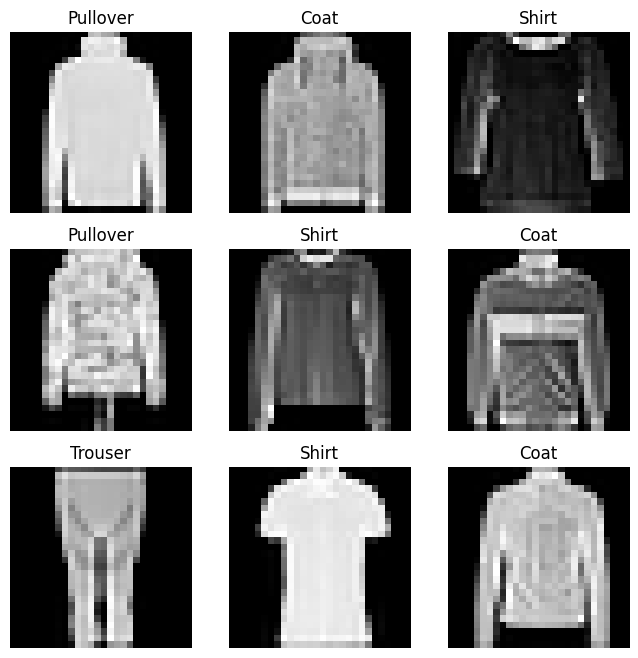

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
""" Create model
To define a neural network in PyTorch, we create a class that inherits from nn.Module.
We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function.
To accelerate operations in the neural network, we move it to the accelerator such as CUDA, MPS, MTIA, or XPU.
If the current accelerator is available, we will use it. Otherwise, we use the CPU.
"""
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # how data (x) will pass through our network
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


[Build Model](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

In [10]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # stachastic gradient 

In [11]:
# train function takes a DataLoader, model, loss function, optimizer
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)                 # 1. forward propagation
        loss = loss_fn(pred, y)         # 2. determine the loss (or error)

        # Backpropagation
        loss.backward()                 # 3. back propagation
        optimizer.step()                # 
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
# training and testing
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295844  [   64/60000]
loss: 2.287245  [ 6464/60000]
loss: 2.266198  [12864/60000]
loss: 2.259517  [19264/60000]
loss: 2.236882  [25664/60000]
loss: 2.203304  [32064/60000]
loss: 2.210291  [38464/60000]
loss: 2.169554  [44864/60000]
loss: 2.157506  [51264/60000]
loss: 2.122989  [57664/60000]
Test Error: 
 Accuracy: 49.4%, Avg loss: 2.121495 

Epoch 2
-------------------------------
loss: 2.133972  [   64/60000]
loss: 2.120826  [ 6464/60000]
loss: 2.058563  [12864/60000]
loss: 2.075439  [19264/60000]
loss: 2.013564  [25664/60000]
loss: 1.949933  [32064/60000]
loss: 1.971844  [38464/60000]
loss: 1.882282  [44864/60000]
loss: 1.879268  [51264/60000]
loss: 1.802546  [57664/60000]
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.804809 

Epoch 3
-------------------------------
loss: 1.848291  [   64/60000]
loss: 1.808667  [ 6464/60000]
loss: 1.688841  [12864/60000]
loss: 1.737529  [19264/60000]
loss: 1.628140  [25664/60000]
loss: 1.580789  [32064/600

In [14]:
# save the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [15]:
# loading saved model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [16]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


[save, load model](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html)